# STL to extract trend and seasonality

[Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

In this notebook we demonstrate how to use STL to extract seasonality and trend from a time series. 

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

# Load data

In [2]:
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"]
)

In [3]:
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


Text(0, 0.5, 'Retail Sales')

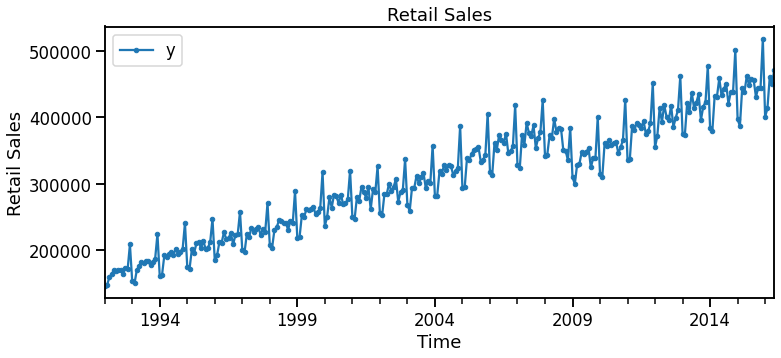

In [4]:
ax = df.plot(marker=".", figsize=[12, 5])
ax.set_title("Retail Sales")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")

# STL parameters

STL has a number of parameters which mostly parameterise the multiple applications of LOESS that occur in the algorithm. The default values of these parameters are typically good enough and the only parameters that requires some attention are the `seasonal`, `period`, and `robust` parameter.

`seasonal`: Determines the window size for LOESS used when smoothing the seasonal component (i.e, the cycle-subseries). As a reminder, the cycle-subseries is the time series formed by the sequence of values from the same period in the seasonal cycle (e.g., the sequence of all the values which occured on January over each year, the sequence of all the values which occured on February over each year, etc.). Hence, this parameter determines how smooth the seasonal component is for the same period (e.g., every January) across multiple seasonal cycles (e.g, multiple years).

`period`: The periodicity of the seasonal component (e.g., for yearly seasonality and monthly data, this would be 12 because the seasonal pattern repeats every 12 periods). This variable is used to determine the cycle-subseries and also in the low pass filtering step of the algorithm.

`robust`: A flag to use robustness weights during regression in LOESS. This ensures robustness to outliers.

For completeness we describe the other parameters in more detail below and illustrate where adjusting some of these parameters could be useful later in the notebook.

The main parameters of STL come about from the repeated use of LOESS to smooth various time series in the algorithm. LOESS is used in the following areas in the STL aglorithm, we specify the corresponding LOESS parameters:

1) Smoothing the seasonal component (i.e., the seasonal cycle-subseries)
- `seasonal`: LOESS window size
- `seasonal_deg`: Degree of the polynomial to use when doing regression in LOESS. 
- `seasonal_jump`: Reduces computational cost of applying LOESS by not evaluating LOESS at every data point but instead evaluating it at a given point and then skipping the number of points specified by this parameter before evaluating LOESS again at a new data point. The intermediate skipped points are evaluated using a linear interpolation instead.

2) Low pass filtering the cycle-subseries
- `low_pass`: LOESS window size
- `low_pass_deg`: Degree of the polynomial to use when doing regression in LOESS. 
- `low_pass_jump`: Reduces computational cost of applying LOESS by not evaluating LOESS at every data point but instead evaluating it at a given point and then skipping the number of points specified by this parameter before evaluating LOESS again at a new data point. The intermediate skipped points are evaluated using a linear interpolation instead.

3) Smoothing the trend component after de-seasonalising the data
- `trend`: LOESS window size
- `trend_deg`: Degree of the polynomial to use when doing regression in LOESS. 
- `trend_jump`: Reduces computational cost of applying LOESS by not evaluating LOESS at every data point but instead evaluating it at a given point and then skipping the number of points specified by this parameter before evaluating LOESS again at a new data point. The intermediate skipped points are evaluated using a linear interpolation instead.

# Using STL to extract trend and seasonality

In [5]:
# Perform STL decomposition
res = STL(
    endog=df["y"],  # Y values
    period=12,  # The periodicity of the seasonal component
    seasonal=7,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()

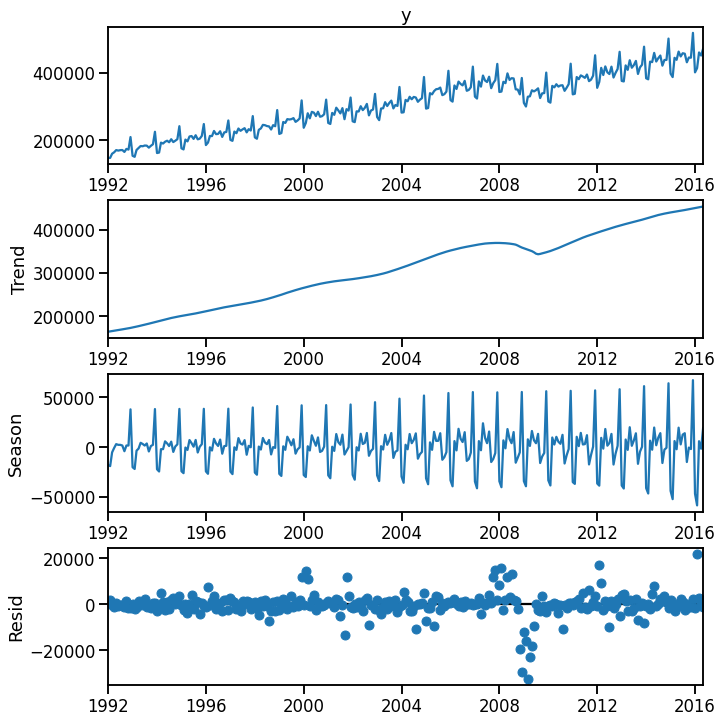

In [6]:
# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

In [7]:
# Extract the trend and seasonality individually
df["trend"] = res.trend
df["seasonal"] = res.seasonal
df.head()

,y,trend,seasonal
ds,,,
1992-01-01,146376,163507.268049,-18105.934264
1992-02-01,147079,164270.425274,-19220.032341
1992-03-01,159336,165042.317260,-5396.563294
1992-04-01,163669,165822.245976,-885.576431
1992-05-01,170068,166609.427740,2929.056385


Text(0, 0.5, 'Seasonal component')

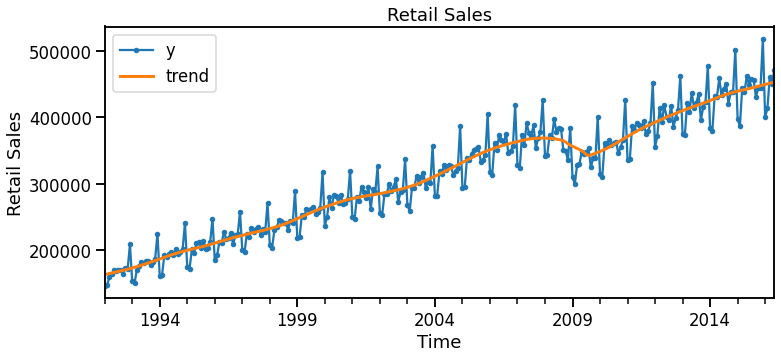

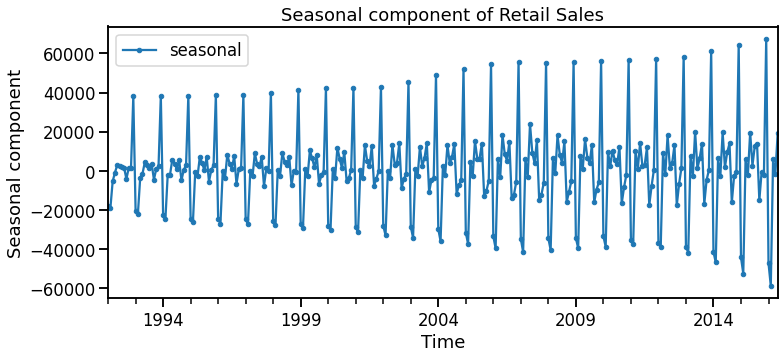

In [9]:
# Plot the trend
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="trend", ax=ax, linewidth=3)
ax.set_title("Retail Sales")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")


# Plot seasonality
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="seasonal", marker=".", ax=ax)
ax.set_title("Seasonal component of Retail Sales")
ax.set_xlabel("Time")
ax.set_ylabel("Seasonal component")

# Obtaining constant seasonality

With the parameters we used in the previous section the magnitude of the seasonal component can change over time. This means, for example, the magnitude of the January component of the seasonality can vary with time. Depending on the context this may be a desired property or not. This behaviour arises from the smooth curve that is fitted to the cycle sub-series.

We can see this by plotting the seasonal component and the de-trended data for each cycle sub-series (i.e., for each in month this case).

In [ ]:
# Perform STL decomposition
res = STL(
    endog=df["y"],  # Y values
    period=12,  # The periodicity of the seasonal component
    seasonal=7,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()

# Extract the trend and seasonality individually
df["trend"] = res.trend
df["seasonal"] = res.seasonal
df["y_detrended"] = df["y"] - df["trend"]

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[15, 20])
ax = ax.flatten()
for i in range(0, 12):
    df[df.index.month == i + 1].plot(y="seasonal", marker=".", ax=ax[i])
    df[df.index.month == i + 1].plot(
        y="y_detrended", marker=".", linestyle="", ax=ax[i]
    )
    ax[i].set_title(f"month {i+1}")
    ax[i].set_xlabel("Time")

plt.tight_layout()

We can see the smooth curve that STL has fit to each cycle sub-series. As a reminder, the smooth fit for each cycle sub-series is obtained through a LOESS fit.

Hence, if we wanted a seasonal component with a constant magnitude over time, then we would want each cycle sub-series to be a constant (i.e., a flat line). This would mean, for example, the January component of the seasonality has a fixed magnitude over time.

This can be achieved by increasing the window of the LOESS smoothing for the seasonal component to encompass a large fraction of the data (i.e., set `seasonal` to a value comparable or larger than the length of a cycle sub-series). However, this would still fit a straight line through each cycle-subseries, which is not what we want. We can set the degree of the polynomial fit of LOESS to zero, this means that during LOESS rather than taking a linear regression of a subset of data to fit a line it instead just takes the simple average of the subset of data to fit a flat line. This can be achieved by setting `seasonal_deg` to 0.

Let's show this below.

In [ ]:
# Perform STL decomposition
res = STL(
    endog=df["y"],  # Y values
    period=12,  # The periodicity of the seasonal component
    seasonal=1001,  # Determines the window size for LOESS used
    # when smoothing the seasonal component
    # (i.e, the cycle-subseries)
    seasonal_deg=0,  # Fit a constant value (i.e., flat line) rather
    # than linear regression during LOESS smoothing
    # of seasonal component
    robust=True  # Flag to use robust regression when
    # fitting the LOESS curves so the fit
    # is robust to outliers
).fit()

In [ ]:
# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

In [ ]:
# Extract the trend and seasonality individually
df["trend"] = res.trend
df["seasonal"] = res.seasonal
df["y_detrended"] = df["y"] - df["trend"]

# Plot the cycle-subseries
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[15, 20])
ax = ax.flatten()
for i in range(0, 12):
    df[df.index.month == i + 1].plot(y="seasonal", marker=".", ax=ax[i])
    df[df.index.month == i + 1].plot(
        y="y_detrended", marker=".", linestyle="", ax=ax[i]
    )
    ax[i].set_title(f"month {i+1}")
    ax[i].set_xlabel("Time")

plt.tight_layout()

Note: The larger residuals seen in the residual plot above indicate this may be a poorer fit to the data. However, the use case and domain knowledge should be used to determine whether a fixed magnitude seasonal component is desired or not.